# Procedurally Provisioned Access Control with ROS2

## Introduction

This notebook demontrates procedurally provisioning access control policies for ROS2, as well as basic verification methods for evaluating transport compliance with respect to the symbolic profile description. This is done through the use of two new developing frameworks:
* [ComArmor](https://github.com/ComArmor):  a profile configuration language for defining Mandatory Access Control (MAC) policies for communication graphs.
* [Keymint](https://github.com/keymint): a workspace build tool for compiling cryptographic artifacts used in securing middleware systems like ROS, DDS, etc.

In this tutorial, we extract a topological representation of the example ROS application we’d like to secure by learning from demonstration, i.e. via logging DDS discovery data published at runtime to then generate a minimal satisfactory policy in ComArmor. Keymint is then used generate the necessary transport artifacts that encompass the ComArmor policy. To verify the secure transport complies with the original policy at runtime, basic exhaustive test analysis is performed by exploring all possible subject and object exchanges. We then compare the test results from the transport analysis with the original symbolic graph learned to determine the false positive and negative instances in the policy’s enforcement.

For repeating and reproducing our experimental results, this notebook has also been made available in its complete form. The experimental procedure presented additionally exemplifies a typical workflow using ComArmor and Keymint.

## Setup

We begin by importing a number of core IPython utilities for reading and displaying or procedure for the reader.

In [1]:
from IPython.display import display, IFrame, Image, Markdown, SVG

Next we include a few local custom function used in testing the target implementation.  
See this repository directory for function source code.

In [2]:
from log_progress import log_progress
from simple_init_test import test_node

Finally, we import several modules for graph, file I/O, and profile operations.

In [3]:
import difflib
import multiprocessing
import networkx as nx
import os 

from copy import deepcopy
from xml.etree import ElementTree

from comarmor.graph.utils import add_edges_from_profile, check_edges_from_profile, colors, directions
from comarmor.profile import Profile
from comarmor.transport.dds.rti.utils import get_profile_from_discovery
from comarmor.xml.utils import beautify_xml

Here, we just define some simple helper function to support simple XML and file diff syntax highlight for readability.

In [4]:
def display_xml_markdown(data):
    if type(data) is str:
        display(Markdown('``` xml\n' + data + '\n```'))
    elif type(data) is ElementTree.Element:
        display(Markdown('``` xml\n' + ElementTree.tostring(data).decode('utf-8') + '\n```'))

def display_diff_markdown(a, b, fromfile, tofile, n=4, lineterm=''):
    aa = a.splitlines()
    bb = b.splitlines()
    diffs = difflib.unified_diff(a=aa, b=bb, fromfile=fromfile, tofile=tofile, n=n, lineterm=lineterm)
    diff = '\n'.join(diffs)
    display(Markdown('``` diff\n' + diff + '\n```'))

Additionally, we define a simple plotting function for generating and saving resulting figures.  
Readers my also peruse through figures in higher resolution or vector graphic form within the local `figs/` directory.

In [5]:
def plot_graph_figure(G, file_name, view='png'):
    A = nx.nx_agraph.to_agraph(G)
    A.add_subgraph()
    if view is 'pdf':
        A.draw(file_name + '.' + 'pdf', prog='dot')
        display(IFrame(file_name + '.' + view, width=950, height=300))
    elif view is 'png':
        A.draw(file_name + '.' + 'png', prog='dot')
        A.draw(file_name + '.' + 'pdf', prog='dot')
        display(Image(file_name + '.' + view))
    elif view is 'svg':
        A.draw(file_name + '.' + 'svg', prog='dot')
        display(SVG(file_name + '.' + view))
    else:
        raise ValueError("No view option: {}".format(view))

## Experiment

To start, we’ll derive a semantic model of the relations between the subjects (ROS Nodes) and objects (ROS Subsystems) we’d like to secure for a target robot application. In this case, we can do this by collecting and recording the discovery data from a the basic ROS2 talker and listener example. Specifically, by sniffing the DDS discovery packets brodacested using tools such as [RTI Admin Console](https://www.rti.com/gettingstarted/adminconsole). Here we load the dumped XML data for inferring the semantic graph.

In [6]:
talker_listener_xml = "talker_listener_discovery_data.xml"
discovery =  ElementTree.parse(talker_listener_xml)
# display_xml_markdown(discovery.getroot())

Next, we get the minimal spanning policy for the application by call our subroten that exames the topics and partitions advertised and infers the permission necessary for continued operation under a Mandatory Access Control (MAC) setting.

From this profile object, we can make subject queries, i.e. filtering the global profile hierarchy for only the profiles (and thus rules) applicable for a given subject URI (or ROS node namespace). This in fact how the Kemint ComArmor plugin uses to create/bootstrap a `keymint_package` for a requested subject. Outputted below is the filtered profiles from extracting applicable policy for the `/talker` node.

In [7]:
profile_element = get_profile_from_discovery(discovery)
profile_tree = ElementTree.ElementTree(profile_element)
profile = Profile(tree=profile_tree)

talker_profile = profile.filter_profile('/talker').tree.getroot()
display_xml_markdown(beautify_xml(talker_profile))

``` xml
<?xml version="1.0" encoding="utf-8"?>
<profiles>
  <profile name="/talker">
    <attachments>
      <attachment>/talker</attachment>
    </attachments>
    <ros_topic qualifier="ALLOW">
      <attachments>
        <attachment>/chatter</attachment>
      </attachments>
      <permissions>
        <ros_publish/>
      </permissions>
    </ros_topic>
    <ros_topic qualifier="ALLOW">
      <attachments>
        <attachment>/clock</attachment>
      </attachments>
      <permissions>
        <ros_subscribe/>
      </permissions>
    </ros_topic>
    <ros_topic qualifier="ALLOW">
      <attachments>
        <attachment>/parameter_events</attachment>
      </attachments>
      <permissions>
        <ros_publish/>
        <ros_subscribe/>
      </permissions>
    </ros_topic>
    <ros_service qualifier="ALLOW">
      <attachments>
        <attachment>/talker/describe_parameters</attachment>
        <attachment>/talker/get_parameter_types</attachment>
        <attachment>/talker/get_parameters</attachment>
        <attachment>/talker/list_parameters</attachment>
        <attachment>/talker/set_parameters</attachment>
        <attachment>/talker/set_parameters_atomically</attachment>
      </attachments>
      <permissions>
        <ros_call/>
        <ros_execute/>
      </permissions>
    </ros_service>
  </profile>
</profiles>

```

In this case, we know the semantic graph and minimal spanning policy to be functionally equivalent. Thus from the global policy description, we can create and render the semantic graph representation.

Shown below is a semantic representation of the computational graph from the simple talker and listener example, modeled as a set of bipartite graphs for each sub-system, with topics and services colored in blue and purple respectively. Here, it happens that only ROS topics and services are exchanged between the ROS nodes, however this multigraph is easily extendable to ROS actions as well. Shared vertices among the bigraphs are encompassed by a set of participating nodes, shown in green. For access control, subject permissions are visualized by directional edges, reflecting the duality of the asymmetric role permissions between subjects and objects.

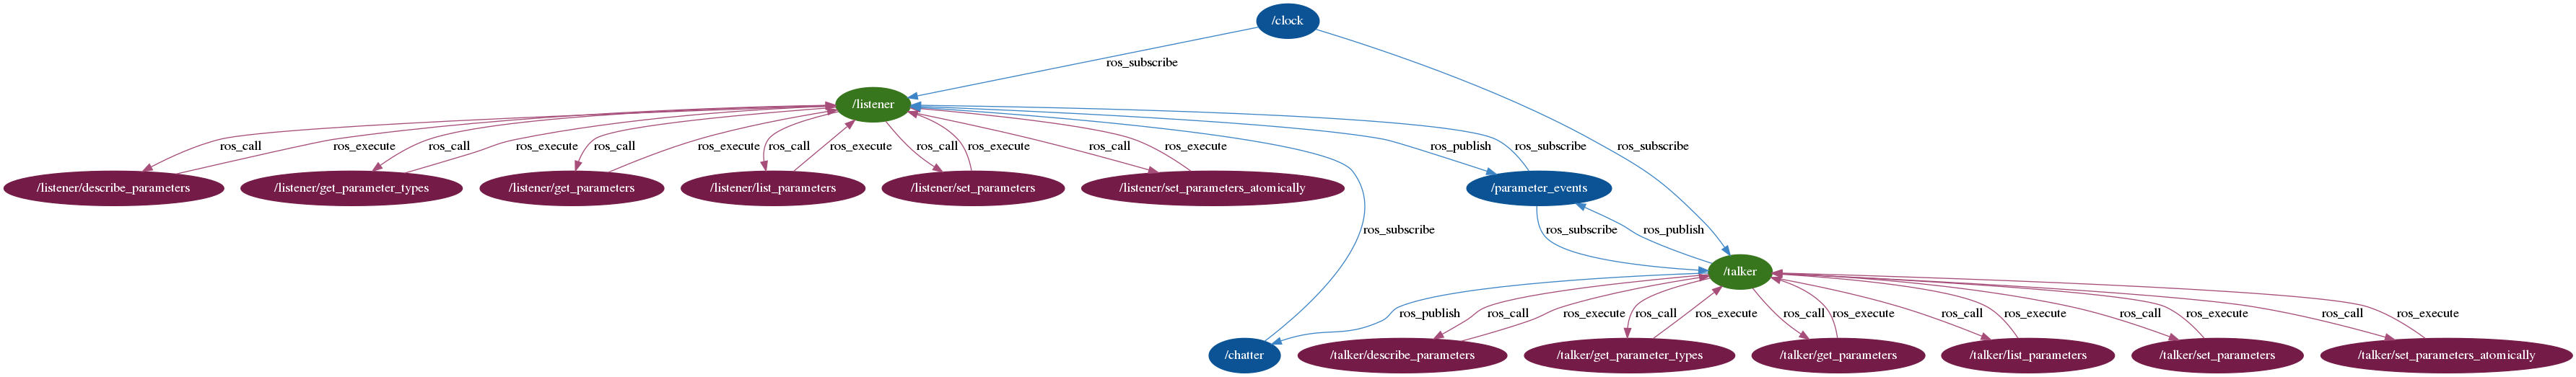

In [8]:
G_s = nx.MultiDiGraph()
add_edges_from_profile(profile, G_s)
plot_graph_figure(G_s, 'figs/G_s')

We show that the semantic graph and minimal spanning policy here are indeed equivalent by evaluating the graph against the minimal spanning policy. As show in the labeled version of the semantic graph, all present edges between subjects and objects are indeed compliant, as denoted by the green allowed actions, and absence of any red denied actions.

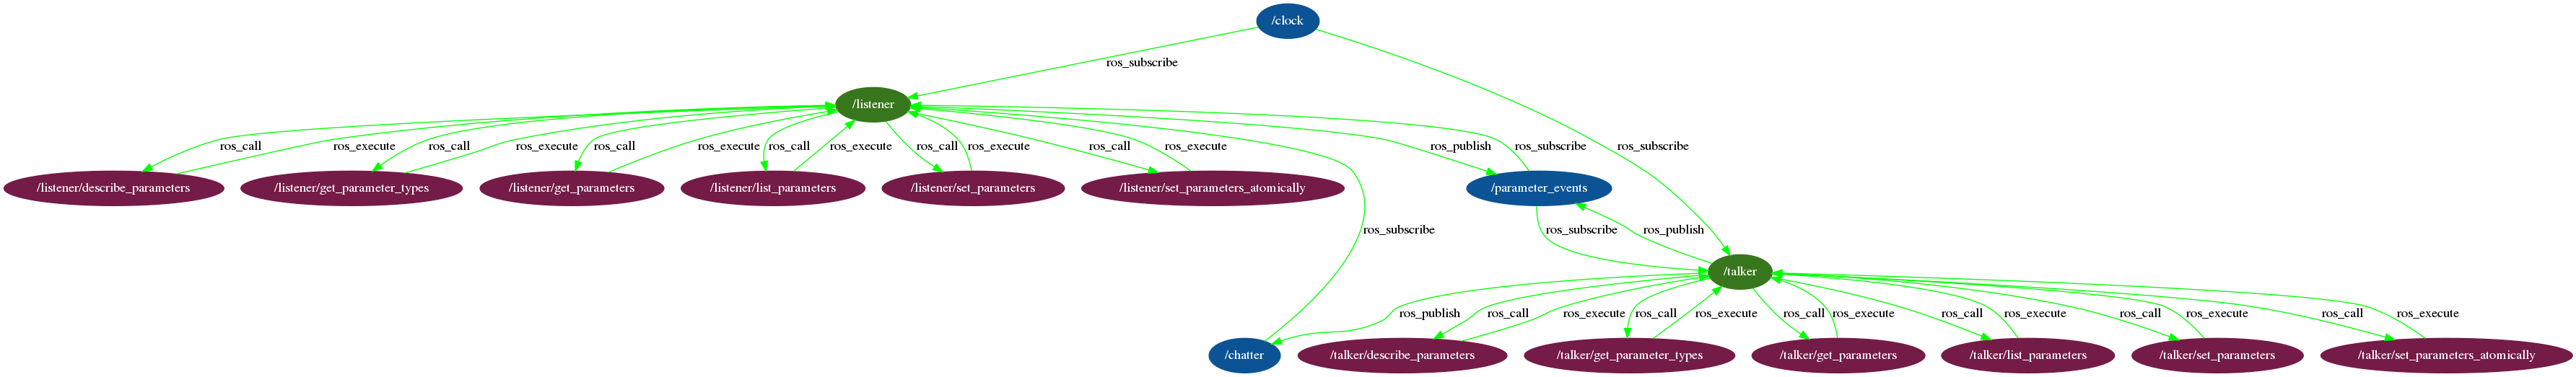

In [9]:
# L_s = G_s.copy()
L_s = G_s # use original graph to plot similar A-graph layout
check_edges_from_profile(profile, L_s)
plot_graph_figure(L_s, 'figs/L_s')

To synthesize an exhaustive test scenario for benchmarking the compliance of the transport policy enforcement, we define a few small helper functions to convert any given bigraph into a fully connected bigraph, while still respecting the correspondence of possible permissions between subjects and object types.

In [10]:
permission_from_object_kind_lookup = {
    'topic': ['publish', 'subscribe'],
    'ros_topic': ['ros_publish', 'ros_subscribe'],
    'ros_service': ['ros_call', 'ros_execute'],
}

def complete_edges_from_pair(G, subject_vertex, object_vertex):
    subject_, subject_values = subject_vertex
    object_, object_values = object_vertex
    permissions = permission_from_object_kind_lookup[object_values['kind']]
    for permission in permissions:
        u, v = directions[permission](subject_, object_)
        if not G.has_edge(u, v):
            G.add_edge(u, v, label=permission, color=colors[permission])

def complete_edges_from_graph(G):
    subjects = [(n, v) for n, v in G.nodes(data=True) if v['type'] == 'subject']
    objects =  [(n, v) for n, v in G.nodes(data=True) if v['type'] != 'subject']
    for subject_vertex in subjects:
        for object_vertex in objects:
            complete_edges_from_pair(G, subject_vertex, object_vertex)

Plotting the fully complete bigraph, we can see all vertex pairings are made cyclic as to ensure every permission for each object is also inspected.

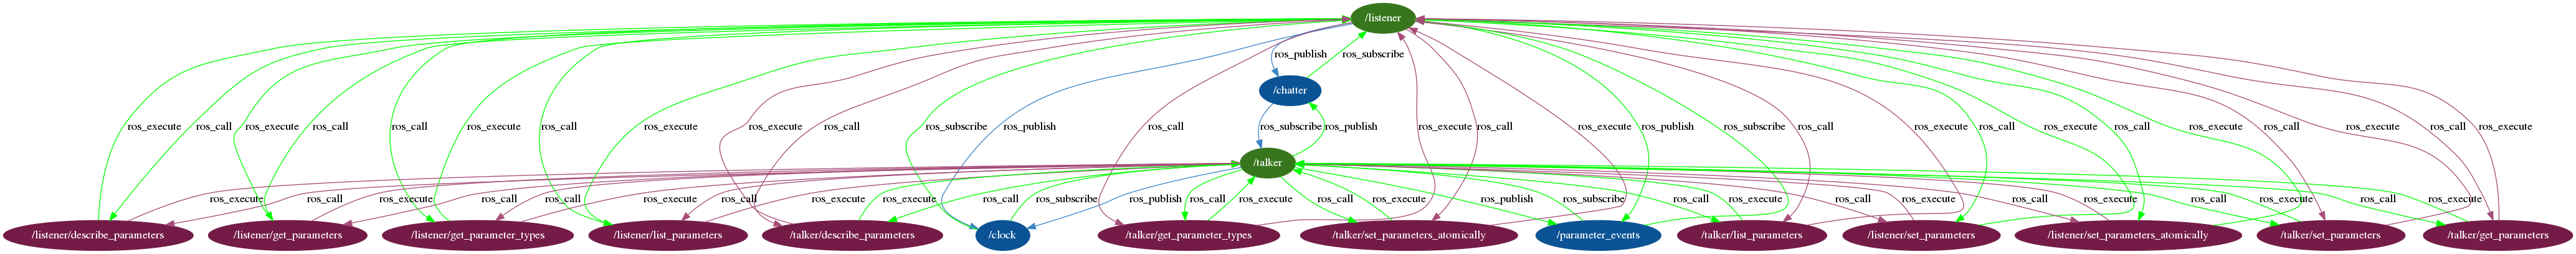

In [11]:
G_fc = G_s.copy()
complete_edges_from_graph(G_fc)
plot_graph_figure(G_fc, 'figs/G_fc')

Evaluating and plotting the labeled graph annotated with the same allow and deny colors as before shows that indeed a majority of edges are labeled as deny. In fact, examining the edes rendered will show that the set of newly added edges are all label as deny, as would be expected from the construction of our minimal spanning policy.

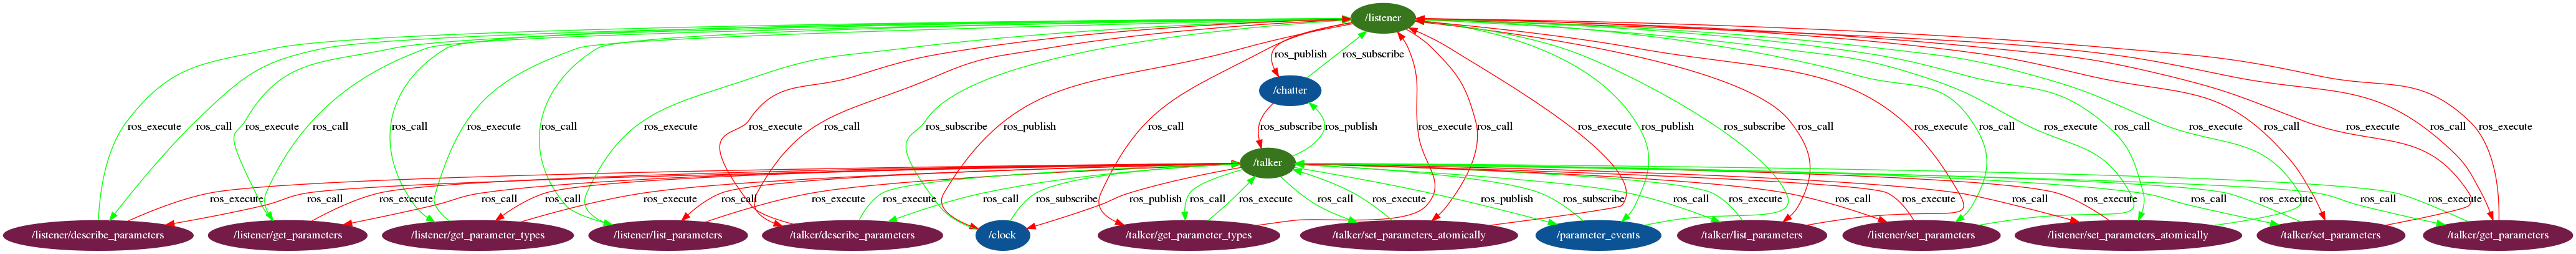

In [12]:
L_fc = G_fc.copy()
check_edges_from_profile(profile, L_fc)
plot_graph_figure(L_fc, 'figs/L_fc')

Now that we have a complete bigraph for testing, we can proceed with initializing a keymint keystore workspace, along with the necessary environment containing Certificate Authorities (CA), global defaults, and what every else a ROS user might need bootstrapped to secure an application.

In [13]:
%%bash
rm -rf keymint_ws
mkdir -p keymint_ws
cd keymint_ws
keymint keystore init --bootstrap keymint_ros
tree .


Utilizing profile 'default_keymint_ros2_comarmor' with context:
--------------------------------------------------------------------------------
private_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/private
profile_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/profile
 public_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/public
--------------------------------------------------------------------------------
+++ Initializing 'default_keymint_ros2_comarmor'
++++ Building Authorities
+++++ Building 'ca'
++++ Installing Authorities
+++++ Installing 'ca'
.
├── private
│   ├── ca.csr.pem
│   └── ca.key.pem
├── profile
│   ├── authorities.xml
│   ├── comarmor.d
│   │   ├── add_two_ints.xml
│   │   ├── common
│   │   │   ├── node
│   │   │   │   ├── parameters.xml
│   │   │   │   └── time.xml
│   │   │   └── node.xml
│   │   ├── launch.xml
│   │   └── talker_listener.xml
│   ├── keymint_profile.xml
│ 

Noted from the `tree` listing above, we see that Keymint has provided us with a working CA and default profile arrangement for its ComArmor plugin. We’ll use the single CA as the authority for both identity and permission signatures. This of course can be overridden or customized in keymint keystore profile config, but we’ll use the simple defaults here for now.

We’ll replace the default profiles bootstraped in `comarmor.d` profile configuration directory with the one aquared from the logged dicovery data. This is where our keyment keystore defaults are set to search for when creating new keymint_packages.

In [14]:
%%bash
rm -rf keymint_ws/profile/comarmor.d/*

In [15]:
profile_path = 'keymint_ws/profile/comarmor.d/example.xml'
with open(profile_path, 'w') as f:
    f.write(beautify_xml(profile.tree.getroot()))

By creating the keymint_package for each subject, Keymint incorporates our ComArmor profile and stages the permissions pertinent for each identity into an intermediate representation that is both agnostic to ComArmor as well as the DDS transport.

In [16]:
%%bash
cd keymint_ws
keymint keystore create_pkg talker
keymint keystore create_pkg listener
tree .


Utilizing profile 'default_keymint_ros2_comarmor' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/src/talker
private_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/private
profile_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/profile
 public_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/public
--------------------------------------------------------------------------------
+++ Creating 'default_keymint_ros2_comarmor'
++++ Creating 'permissions.xml'
++++ Creating 'governance.xml'
++++ Creating 'identities.xml'
++++ Creating 'keymint_package.xml'

Utilizing profile 'default_keymint_ros2_comarmor' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keym

We then build the keymint_packages to compile artifacts that closely resemble the final files needed for a secured installment. This step essentially uses the ROS2_DDS Keymint plugin to formulate the permissions in accordance with the schema used by DDS’s default security plugin. A this stage, just about all certificats documents have been generated but not yet signed.

In [17]:
%%bash
cd keymint_ws
keymint keystore build_pkg src/talker --skip-install
keymint keystore build_pkg src/listener --skip-install
tree .


Process package 'talker' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/src/talker
  build_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/build/talker
install_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/install/talker
 public_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/public
private_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/private
--------------------------------------------------------------------------------
+++ Building 'talker'
++++ Building 'permissions.xml'
++++ Building 'governance.xml'
++++ Building '['key.pem', 'csr.pem']'

Process package 'listener' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/noteboo

Given the artifacts are not yet signed, this staggered development cycle provides users the chance to customize the final binaries further before signing and installation.

In [18]:
def patch_permissions_for_ros2_bouncy(tree):
    topicss = tree.findall('permissions/grant/allow_rule/publish/topics')
    for topics in topicss:
        for topic in list(topics):
            if topic.text.endswith('Request'):
                topics.remove(topic)

    topicss = tree.findall('permissions/grant/allow_rule/subscribe/topics')
    for topics in topicss:
        for topic in list(topics):
            if topic.text.endswith('Reply'):
                topics.remove(topic)
    return tree

As of writing, nodes in ROS2 Bouncy neccestate both client and server level access to their own parameter services. Though server level permission are necessary to provide remote access to the nodes local parameters, client level access to these same local services is more of byproduct of how timing options are made configurable. Related: [ros2/sros2/issues/63](https://github.com/ros2/sros2/issues/63) 

In this case, we’ll patch the permission file to remove `ros_call` level access for these services for only the talker subject, but not for the listener, as this will demonstrate both false positive and negative policy decisions in the current transport implementation.

In [19]:
permissions_path = 'keymint_ws/build/talker/permissions.xml'
permissions = ElementTree.parse(permissions_path)
patched_permissions = patch_permissions_for_ros2_bouncy(deepcopy(permissions))

The exact diff applied to the original permission files for the talker is also shown below.

In [20]:
permissions_str = beautify_xml(permissions.getroot())
patched_permissions_str = beautify_xml(patched_permissions.getroot())

with open(permissions_path, 'w') as f:
    f.write(patched_permissions_str)

display_diff_markdown(a=permissions_str,
                      b=patched_permissions_str,
                      fromfile='permissions',
                      tofile='patched_permissions')

``` diff
--- permissions
+++ patched_permissions
@@ -14,14 +14,8 @@
         <publish>
           <topics>
             <topic>rt/chatter</topic>
             <topic>rt/parameter_events</topic>
-            <topic>rq/talker/describe_parametersRequest</topic>
-            <topic>rq/talker/get_parameter_typesRequest</topic>
-            <topic>rq/talker/get_parametersRequest</topic>
-            <topic>rq/talker/list_parametersRequest</topic>
-            <topic>rq/talker/set_parametersRequest</topic>
-            <topic>rq/talker/set_parameters_atomicallyRequest</topic>
             <topic>rr/talker/describe_parametersReply</topic>
             <topic>rr/talker/get_parameter_typesReply</topic>
             <topic>rr/talker/get_parametersReply</topic>
             <topic>rr/talker/list_parametersReply</topic>
@@ -32,14 +26,8 @@
         <subscribe>
           <topics>
             <topic>rt/clock</topic>
             <topic>rt/parameter_events</topic>
-            <topic>rr/talker/describe_parametersReply</topic>
-            <topic>rr/talker/get_parameter_typesReply</topic>
-            <topic>rr/talker/get_parametersReply</topic>
-            <topic>rr/talker/list_parametersReply</topic>
-            <topic>rr/talker/set_parametersReply</topic>
-            <topic>rr/talker/set_parameters_atomicallyReply</topic>
             <topic>rq/talker/describe_parametersRequest</topic>
             <topic>rq/talker/get_parameter_typesRequest</topic>
             <topic>rq/talker/get_parametersRequest</topic>
             <topic>rq/talker/list_parametersRequest</topic>
```

Now that the build files have been patched, we can resume installation: signing the identity certificates and binding the permission and governance files to the respective identities.

In [21]:
%%bash
cd keymint_ws
keymint keystore build_pkg src/talker --skip-build
keymint keystore build_pkg src/listener --skip-build
tree .


Process package 'talker' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/src/talker
  build_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/build/talker
install_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/install/talker
 public_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/public
private_space => /home/ruffsl/git/ruffsl/ros2_docker_demos/sros2/notebook/keymint_ws/private
--------------------------------------------------------------------------------
+++ Installing 'talker'
++++ Installing 'permissions.p7s'
++++ Installing 'governance.p7s'
++++ Installing '['key.pem', 'cert.pem']'
++++ Installing '['ca.cert.pem']'

Process package 'listener' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl

The necessary SRO2 environment variables must also be set. Here, we simply point our root security directory to be the install path from our keymint keystore workspace.

In [22]:
cwd = os.getcwd()
os.environ["ROS_SECURITY_ROOT_DIRECTORY"] = os.path.join(cwd, 'keymint_ws', 'install')
os.environ["ROS_SECURITY_ENABLE"] = "true"
os.environ["ROS_SECURITY_STRATEGY"] = "Enforce"

For testing, we segment the fully connected multigraph into trios: subject, object, and permission. This allows us to feed each edge in the graph to a unit test case subrotue. Here we rely on RTI Connext’s or FastRTPS's `Security_AccessControl_check` to validate the creation of any DDS a data reader or writer endpoint.

Here we make the assumption that the same Policy Decision Point (PDP) logic used for self checking is also applied for incoming connections. If such is not the case, then a more though test scenario must be constructed where not only the subject in question must be sythised for access testing, but also the peer that is in position of the object of intent.

Thus, instead of success or failure in initialization denoting a test classification label, as is the case here, a more rigorous test, such as between two different transport vendors, would necessitate the label corresponding to the success or failure of the action on the remote object. Additionally, objects here are in effect channels in the data bus. For testing more subjective policies that are data instance specific, e.g. using data key or tags, the method used here may not suffice.

In [23]:
L_tp = G_fc.copy()
unit_cases = []
for u, v, a in L_tp.edges(data=True):
    subject_name = u if L_tp.node[u]['type'] == 'subject' else v
    object_name  = u if L_tp.node[u]['type'] != 'subject' else v
    unit_case = {
        'test' : {
            'subject_name': subject_name,
            'object_kind': L_tp.node[object_name]['kind'],
            'permission': a['label'],
            'object_name': object_name,},
        'edge': {
            'u': u,
            'v': v,
        }       
    }
    unit_cases.append(unit_case)

Here we define a simple test test routine for bookkeeping qualifier labels inferred from transport test outcomes.

In [24]:
def test_case(unit_case):
    qualifier = test_node(**unit_case['test'])
    unit_case['test']['qualifier'] = qualifier
    unit_case['test']['color'] = colors[qualifier]
    unit_case['edge']['qualifier'] = qualifier
    unit_case['edge']['color'] = colors[qualifier]
    return unit_case['edge']

## Results



In [25]:
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 4   # arbitrary default
pool = multiprocessing.Pool(processes=cpus)
results = pool.map(test_case, unit_cases)

We enumerate through the results to update the labels for the complete bigraph.

In [26]:
for result in results:
    L_tp[result['u']][result['v']][0]['color'] = result['color']
    L_tp[result['u']][result['v']][0]['qualifier'] = result['qualifier']

We can then plot the labeled bigraph in its entirety. However the results shown in this figure are perhaps too obfuscated from the complexity of the topology.

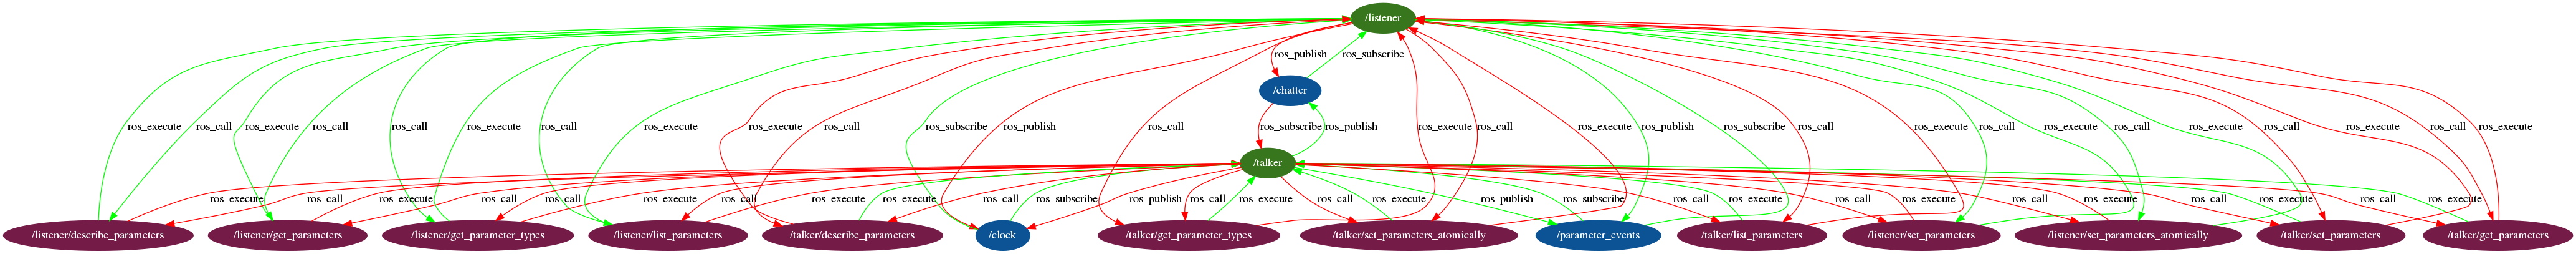

In [27]:
plot_graph_figure(L_tp, 'figs/L_tp')

In [28]:
L_tp_edges = L_tp.edges(keys=True)
G_s_edges = G_s.edges(keys=True)

To clarify the rendering of the results, we can take advantage of subset arrangement between the original symbolic graph and that which was tested. Simply put, we separate our focus on either the intersection v.s. relative complements between the two graphs. We can then refine the labels by annotating the true/false positives/negatives, where false positive and negatives are undesired faults in the transport policy implementation.

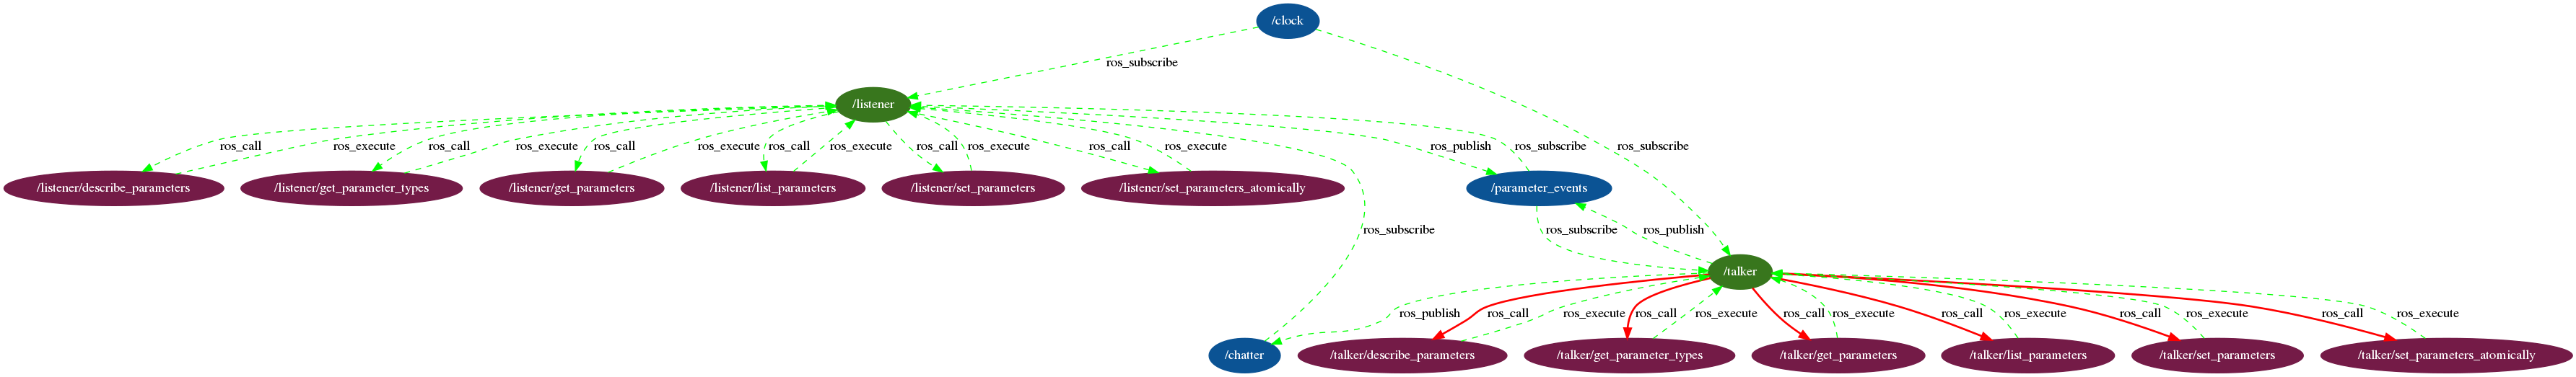

In [29]:
intersec_of_G_s_in_L_tp = L_tp.copy()
for edge in L_tp_edges:
    if edge not in G_s_edges:
        intersec_of_G_s_in_L_tp.remove_edge(*edge)
    else:
        edge_data = intersec_of_G_s_in_L_tp.edges[edge]
        if edge_data['qualifier'] == 'allow':
            edge_data['style']= 'dashed'
        elif edge_data['qualifier'] == 'deny':
            edge_data['style']= 'bold'

plot_graph_figure(intersec_of_G_s_in_L_tp, 'figs/intersec_of_G_s_in_L_tp')

Shown are the annotated graphs depicting transport test results where only the subject $talker$'s policy amended for the empty partition. The colored edges green/red correspond to allowed/denied actions respectively. Additionally, *True* positive/negative labels are *dashed*, while **False** positives/negatives are **solid**.

The graph above depicts the intersection between labels from $G_{tp}$ with graph $G_{s}$, while the graph below is the relative complement of $G_{s}$ in $G_{tp}$. Given the amendment, $talker$ is no longer capable of using its credentials as a client to its own parameter services, as shown via **solid** red edges. However, $listener$ remains capable of accessing its own parameter services from both client and server roles.

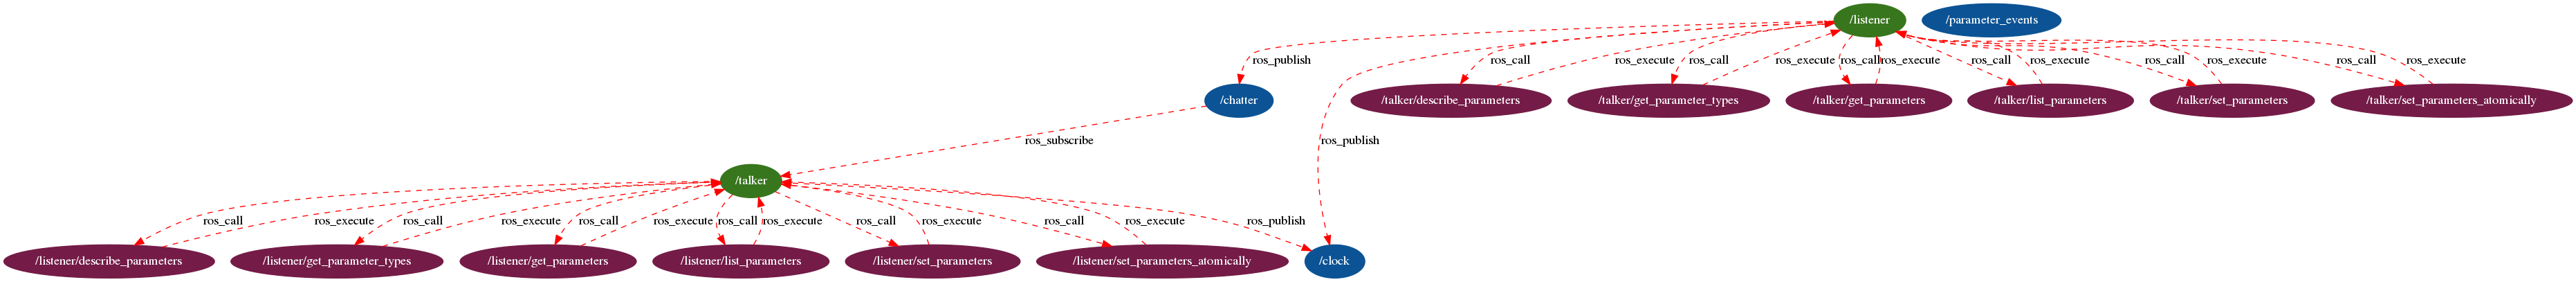

In [30]:
rc_of_G_s_in_L_tp = L_tp.copy()
for edge in L_tp_edges:
    if edge in G_s_edges:
        rc_of_G_s_in_L_tp.remove_edge(*edge)
    else:
        edge_data = rc_of_G_s_in_L_tp.edges[edge]
        if edge_data['qualifier'] == 'deny':
            edge_data['style']= 'dashed'
        elif edge_data['qualifier'] == 'allow':
            edge_data['style']= 'bold'

plot_graph_figure(rc_of_G_s_in_L_tp, 'figs/rc_of_G_s_in_L_tp')

A nuance exists here in that $talker$ and $listener$ currently instatate on client level access to their own parameters in order to filter out change events to `use_sim_time`. However, client level access here is otherwise unwarranted, and with upcoming parameters refactoring, such is expected to be resolved in future releases.

https://github.com/ros2/sros2/issues/63  
https://github.com/ros2/ros2/issues/432